# Graph Theory and Social Network Analysis

In this project we are going to conduction network analysis for corporations. The first step in any analysis consists of getting meaningful data. To obtain a network of companies we are going to take advantage of the Twitter API, which allows us to obtain data from known corporations. Twitter does not provide direct information about whether or not an account belongs to a corporation. Thus, we need to develope and train a model which is able to classify an account as corporate or private. Once we obtain corparate accounts we obtain the information on how they relate to each other. This allows us to apply graph theoretical analysis in order to obtain meaningful information and draw inference about the network.

## Data
Our goal is to obtain an understanding of how corporations relate to each other. In order to relate corporations to each other we take advantage of the Twitter API. Twitter is Social Media platform which allows users to publicly share information, called "tweets" and follow other users among many other things. For the purpose of this study we are interested in which company follows which. Assuming we know an account belongs to a corporation, the Twitter API allows to identify which other users this account follows. However, there is no indication whether or not this account belongs to a corporation or an individual or a corporation. Hence we need a model that estimates whether or not an account belongs to a corporation or not. 

### Training Data
For the pupose of training a model, we need a sample of known corporate- and presumably individual accounts. For the classification task a sample of 358 manually labeled known corporations and 200 private accounts was collect. For user accounts, the Twitter API provides user information such as: 'protected' (bool), 'location' (nominal), 'description' (nominal), 'followers_count' (numeric, discrete), 'following_count' (numeric, discrete), 'tweet_count' (numeric, discrete), 'listed_count', 'url' (nominal), 'verified' (bool), 'entities' (nominal), 'name' (nominal). 

### Transformations
The numeric and boolean variables are left as they are and the nominal variables are transfomed to boolean variables that take are "True" if there is an entry and "False" if there is not. 

### Additions
To the transformed dataset we add the boolean variable "Corporate" which takes the values "Corparate" if the account belongs to a known corporation, and "private" if it does not.

## Model 
Since our variable of interest is a boolean variable we restrict ourself to classification models in order predict whether or not an account belongs to a corporation or not. There are several popular classification methods among which we are going to compare: logistic regression, support vector machines and random forests.

### Logistic Regression
We are interested in predicting whether or not a user account belongs to a corporation or not. Let $y_i = 1$ if the $i$'th users account belongs to a corpora $y_i = 0$ otherwise. Since $y_i$ can only take on two values, we can consider it as Bernoulli random variable $y_i \sim Ber(p_i)$ whose probablity mass function is described by: $f(y_i) = p_i^{y_i}(1-p_i)^{1-y_i}$. Where $p_i$ is the probability of $y_i = 1$. Note that probabilities can only take on values between zero and one. Our goal is to use the user data to estimate the unknown quantity $p_i$ by a linear combination of the user data $x_{i,j}:$ $\beta_1x_{i,1} + \beta_2x_{i,2} + ... + \beta_n x_{i,n} = X_i'\beta$. The key issue is $p_i$ can only take values between zero and one, however $X_i'\beta$ can take values between $\pm \infty$.  Thus we can not just write: $p_i = X_i'\beta$, since the two sides can take on different values. In order to meaningfully relate the two quantities we have to either place a restriction on the $\beta$'s, or to use a function that ensures that both $p_i$ and $X_i'\beta$ can take the same values. The latter approach works by useing a "link" function:

$$
g(p_i) = log(\frac{p_i}{1-p_i}) =  X_i'\beta
$$

The name 'logistic' regression comes from using the logarithm of the odds ratio as the link function. The following plot show's why this approach works. We can see that for all values of $p$ between zero and one, the $log(\frac{p}{1-p})$ can take positives and negatives values that would go to $\pm \infty$ if we make the intervalls small enough. Thus by using the log odds ratio, we achieved the goal of mapping the probabilites $p_i$ into the $X_i'\beta$ space. 



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import sklearn as sk
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from scipy import sparse
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import json
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



Text(0, 0.5, 'log(p/(1-p))')

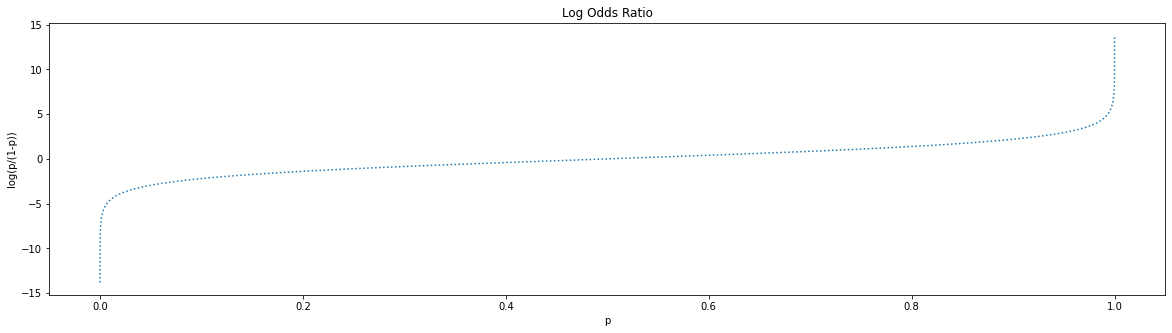

In [2]:
# Probabilities can take values from 0 to 1. For p = 1 we have log (1/0) which is not defined 
p = np.arange(0.000001, 1, step = 0.000001)

# log odds ratio for different values of p
log_odds = np.log(p/(1-p))

# plot log odds ratio
plt.figure(figsize=(20, 5))
plt.plot(p, log_odds, linestyle = 'dotted')
plt.title("Log Odds Ratio")
plt.xlabel("p")
plt.ylabel("log(p/(1-p))")

The likelyhood of observing $n$ independent and indetically distibuted Bernoulli random variables is given by:
$$
L(\beta) = \prod_{i = 1}^np_i^{y_i}(1-p_i)^{1-y_i} = p_i^{\sum_{i = 1}y_i}(1-p_i)^{\sum_{i = 1}(1-y_i)} = p_i^{\sum_{i = 1}y_i}(1-p_i)^{n - \sum_{i = 1}y_i}
$$

Since it is easier to calculate with sums then with products, we take the logarithm of both sides of the equation and obtain:

$$
\begin{align*}
l(\beta) &=  \sum_{i = 1}y_ilog(p_i) + (n - \sum_{i = 1}y_i)log(1-p_i) \\
         &= \sum_{i = 1}y_ilog(p_i) + nlog(1-p_i) - \sum_{i = 1}y_ilog(1-p_i) \\
         &= \sum_{i = 1}y_i(log(p_i)-log(1-p_i)) + nlog(1-p_i) \\
         &= \sum_{i = 1}y_ilog(\frac{p_i}{1-p_i}) + nlog(1-p_i) \\
\end{align*}
$$

This is where we apply the equation $log(\frac{p_i}{1-p_i}) = X_i'\beta$. Additionally, note that: 

$$
\begin{align*}
log(\frac{p_i}{1-p_i}) &= X_i'\beta \\
\Rightarrow \frac{p_i}{1-p_i} &= e^{X_i'\beta} \\
\Rightarrow \frac{1-p_i}{p_i} &= \frac{1}{e^{X_i'\beta}} \\
\Rightarrow \frac{1}{p_i} -1 &= \frac{1}{e^{X_i'\beta}} \\
\Rightarrow \frac{1}{p_i} &= 1 + \frac{1}{e^{X_i'\beta}} \\
\Rightarrow \frac{1}{p_i} &= \frac{e^{X_i'\beta}}{e^{X_i'\beta}} + \frac{1}{e^{X_i'\beta}} \\
\Rightarrow \frac{1}{p_i} &= \frac{e^{X_i'\beta} + 1}{e^{X_i'\beta}} \\
\Rightarrow p_i &= \frac{e^{X_i'\beta}}{e^{X_i'\beta} + 1} \\
\Rightarrow 1- p_i &= 1- \frac{e^{X_i'\beta}}{e^{X_i'\beta} + 1} \\
\Rightarrow 1- p_i &=  \frac{e^{X_i'\beta} + 1}{e^{X_i'\beta} + 1}- \frac{e^{X_i'\beta}}{e^{X_i'\beta} + 1} \\
\Rightarrow 1- p_i &=  \frac{1}{e^{X_i'\beta} + 1}\\
\end{align*}
$$

Plugging these values into the log likelyhood, we obtain:
$$
\begin{align*}
l(\beta) &= \sum_{i = 1}y_ilog(\frac{p_i}{1-p_i}) + nlog(1-p_i) \\
         &= \sum_{i = 1}y_iX_i'\beta + nlog(\frac{1}{e^{X_i'\beta} + 1}) \\
         &= \sum_{i = 1}y_iX_i'\beta + n(log(1) - log(e^{X_i'\beta} + 1)\\
         &= \sum_{i = 1}y_iX_i'\beta + n(0 - log(e^{X_i'\beta} + 1)\\
         &= \sum_{i = 1}y_iX_i'\beta - nlog(e^{X_i'\beta} + 1)\\
\end{align*}
$$

Thus we successfully replaced all $p_i$ by a function of $X_i'\beta$, which we can calculate since we have the user data. Here the only unknown quantities are the $\beta$'s. Since we are interested in which $\beta$'s make the observed quantities most likely, we proceed my maximising with resprect to $\beta$ and set to zero:

$$
\begin{align*}
\frac{d}{d\beta}l(\beta) &= \frac{d}{d\beta}(\sum_{i = 1}y_iX_i'\beta - nlog(e^{X_i'\beta} + 1)) \overset{!}{=} 0\\
\end{align*}
$$

However for this expression there exists no closed form solution so we need numeric optimization algorithms to calculate the optimal $\beta$'s. Since $\sum_{i = 1}y_iX_i'\beta - nlog(e^{X_i'\beta} + 1)$ is a convex function (without proof), there exists a unique optimum. Hence we are guaranteed to obtain the $\beta$'s that maximum the likelihood of observing our data. In the following, the results of the estimation, including code are presented. 

### Estimation

In order to estimate the model, the dataset is split in two disjoint parts. The first part, 70% of observations is used to estimate the model, while the remaining 30% are used to test the models performance. Furthermore, ten fold cross-validation is being performed during the estimation process. 


In [8]:
# read data
trng_data = pd.read_csv("/home/vincent/Dropbox/University/Statistik/KURSE/CURRENT/master/graphT/model_trng_data.csv", sep = ',')

# coporations
y = trng_data['corporate']

# user data, remove nominal data and dependend variable
X = trng_data.loc[:, ~trng_data.columns.isin(['id', 'name', 'corporate'])]

# Split data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Perform logistic regression
LR = LogisticRegressionCV(solver='lbfgs', cv = 10, multi_class='ovr',  max_iter=10000).fit(X_train, y_train)

### Performance
As a result of the estimation we obtain the optimal values for $\beta$ and call this maximum $\hat\beta$. Next we can use the inverse link function to obtain our predictor of $\hat{p}_i = g^{-1}(X_i'\hat{\beta})$. Now that we have the estimates for the probabilities, we can use diffenrent thresholds $\tau$ to classify the obtained probabilities to the respective classes. For example for $\tau  = 0.5$ if $\hat{p}_i > \tau \rightarrow $ assign to class $1$ and to class $0$ otherwise. The following graph is called the confusion matrix. It depicts the correct and false prediction of the classification result. In the left column we can see that the model correctly predicted 92 private accounts (topleft) and classified two as corporate (bottom left) which were actually private accounts. The former is called the true-negative and the latter is called the false-positive rate. On the right hand side we can see that 9 (topright) observations were predicted to be corporate accounts which were actually private and 305 (bottonright) were correctly classified as corporate accounts. The former value is called false-negative and the latter the true-positive rate. Essentially our model was able to predict very well the correct label of the observations.  


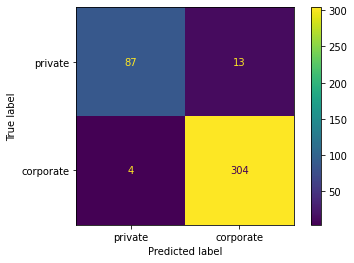

In [9]:
# Predict test data
pred = LR.predict(X_test)

# Predicted probabilities
pred_prob = LR.predict_proba(X_test)

# Confusion Matrix
cm = metrics.confusion_matrix(np.where(y_test == 0, 'private', 'corporate'), np.where(pred == 0, 'private', 'corporate'))

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['private', 'corporate'])
disp.plot()


Another performance measure is called the "Receiver-Operator-Curve" (ROC). The ROC relates the false-positve rate on the x-axis and the true-positive rate on the y-axis for all $\tau$ values ranging form $0-1$. We can see that the ROC has only one point at (0.00651466, 0.91089109). As a comparison the perfect classification is at (0, 1). Hence we conclude that the performs very well in the classification task.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


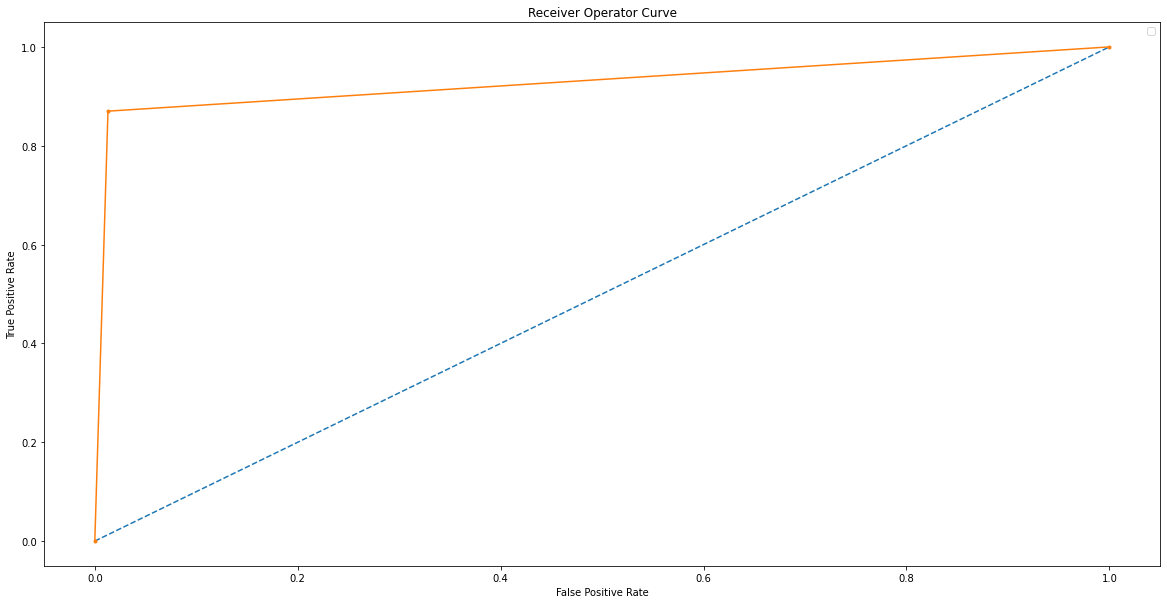

In [10]:
# Calculating the ROC 
preds = pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

ns_probs = [0 for _ in range(len(y_test))]
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
lr_auc = metrics.roc_auc_score(y_test, preds)

ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, pred)
# method I: plt
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
plt.title('Receiver Operator Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
# show the plot

### Application
Now that we have trained an evaluated our model we can apply it to create the network of corporations. First we obtain all the accounts that a particular corporation follows and call theses 'friends'. For the 'friends' we use our model to classify them as corporations or private and keep the corporations. Thus we have a relation from one corporation to possibly many others. We repeat this process to finally obtain our final network.  

## Corporate Network Analysis
There exists a mathematical theory called Graph Theory, which is concerned about analysing and drawing inference about relating objects. We can take advantage of this theory and many of it's existing well established results to describe, analyse and draw inference about the realtionships among our corporations. 

### Notation
In the following the terms graph and network will be used equivalently. Mathematically, a graph is a set of vertices (nodes) $\mathcal{N} =\{n_1, ..., n_k\}$ and lines (edges) $\mathcal{L} = \{l_1,...,l_g\}$ between a pair of nodes, for example $l_j = (n_1, n_2)$.  Thus a graph $\mathcal{G}$ is described by it's nodes and lines between those nodes, hence: $\mathcal{G} = \{\mathcal{N}, \mathcal{L}\}$. In our example nodes are the corporations and the edges refer to which coporations has befriended which. In our example we have what is called a directed graph, meaning that a befriending does not have to be mutal. For example corporation A might follow corporation B but not the other way around. 

In [11]:
# Read network data
corp_network = pd.read_csv('/home/vincent/Dropbox/University/Statistik/KURSE/CURRENT/master/graphT/corp_network.csv')

# Create di-graph object 
G = nx.from_pandas_edgelist(corp_network, source= 'from', target = 'to', create_using=nx.DiGraph)

In [12]:
nx.info(G)

'DiGraph with 111616 nodes and 152971 edges'

### Describtion
We start by describing basic properties of the graph. The graph has a total of  111616  nodes and  152971  edges. One of the key propteries is the degree of a node. For a directed graph we distinguish between in- and outdegree ($d_I(n_i), d_O(n_i)$). Indegree is the number of connections coming into a node, meaning how many other coporations choose to follow it. It is an indicator for popularity, since a large indegree means that many other coporations choose to follow this one. The outdegree refers to the amount connections going out from a node. In our example it would be which other corporations a particular corporation follows. 

In [13]:
indegrees = G.in_degree()
indegr = []

for usr, deg in indegrees:
    indegr.append([usr, deg])

indegree_df = pd.DataFrame(indegr, columns=['User', 'Indegree'])
indegree_df['Indegree'].describe()

count    111616.000000
mean          1.370511
std           1.584549
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          92.000000
Name: Indegree, dtype: float64

The following graph show the histogram of the indegree values. Note that the y-axis is scaled logarithmically, in order to make the results readable. We can see that the vast amount of nodes have few (10 or less) incoming connections and then we observe an exponential decay. There are two nodes with an indegree of 80 or more, indicating that there are only very few "popular" nodes. 

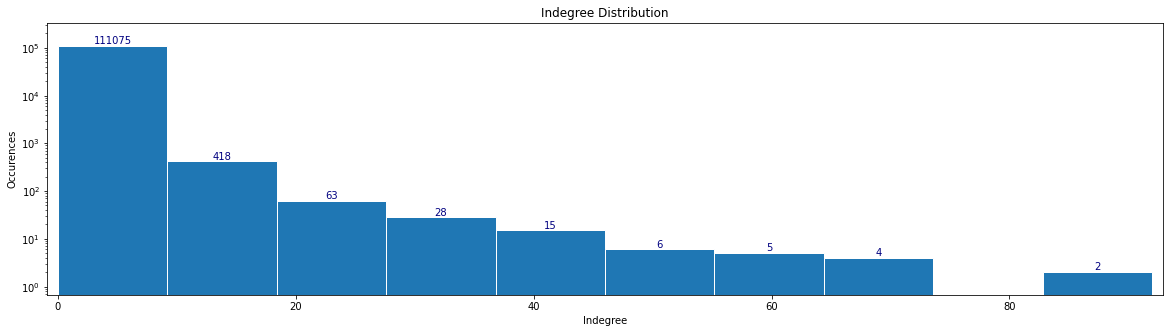

In [14]:
plt.figure(figsize=(20, 5))
values, bins, bars = plt.hist(indegree_df['Indegree'], edgecolor='white', log = True)
plt.title("Indegree Distribution")
plt.xlabel("Indegree")
plt.ylabel("Occurences")
plt.bar_label(bars, fontsize=10, color='navy')
plt.margins(x=0.01, y=0.1)
plt.show()

In [16]:
outdegrees = G.out_degree()
outdegr = []

for usr, deg in outdegrees:
    outdegr.append([usr, deg])

outdegree_df = pd.DataFrame(outdegr, columns=['User', 'Outdegree'])
outdegree_df['Outdegree'].describe()

count    111616.000000
mean          1.370511
std          29.898835
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         948.000000
Name: Outdegree, dtype: float64

Note that the mean of the outdegree is the same of the indegree. This results from the fact that every outgoing node is another nodes incoming so in total the numbers should be the same. Which we can easaly verify:

In [17]:
print("Sum Indegree: ", np.sum(indegree_df['Indegree']), " sum outdegree: ", np.sum(outdegree_df['Outdegree']), " both equal? ", np.sum(indegree_df['Indegree']) == np.sum(outdegree_df['Outdegree']))

Sum Indegree:  152971  sum outdegree:  152971  both equal?  True


Thus sum of indegrees equals the sum of outdegrees and thus the means are also equal. The following graph show the histogram of the outdegree values. Again, the y-axis is scaled logarithmically, in order to make the results readable. We can see that  111340 nodes have an outdegree of 100 or less. The remaining nodes are approximatly uniformly distributed until approximatly 900. Thus we can see that there is a difference in the estimated indegree and outdegree distribution. This indicates that it is much more likely that a node emite many connection then receives them. 

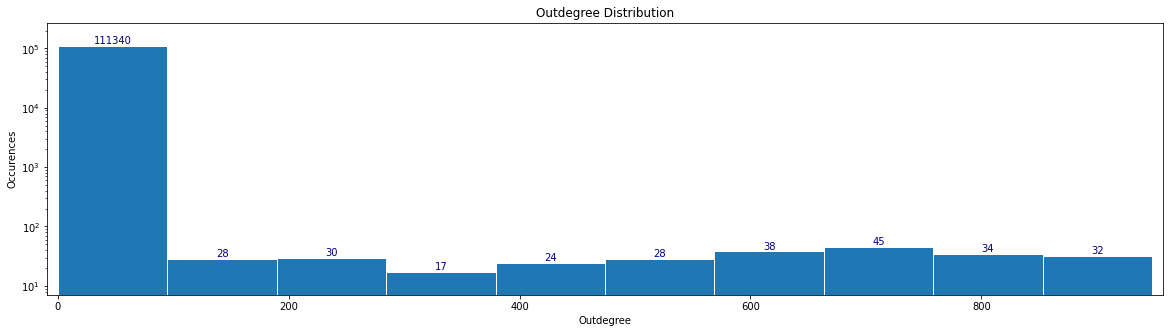

In [19]:
plt.figure(figsize=(20, 5))
values, bins, bars = plt.hist(outdegree_df['Outdegree'], edgecolor='white', log = True)
plt.title("Outdegree Distribution")
plt.xlabel("Outdegree")
plt.ylabel("Occurences")
plt.bar_label(bars, fontsize=10, color='navy')
plt.margins(x=0.01, y=0.1)

The density of a graph is the number of arcs relative to the total number of possible arcs. If there are a total number of $g$ arcs in a directed, then there is a total amount of $g(g-1)$ possible arcs. Thus then density measures the actual- relative to the possible amount of arcs in a graph. A dense graph should have a value close to 1. In our case the density is:

In [20]:
np.sum(indegree_df['Indegree']) / (G.number_of_nodes()*(G.number_of_nodes()-1))

1.2278917674287473e-05

which is rather low. 

For directed graphs we can distinguish between four different types of nodes: 
* Isolate: $d_I(n_i) = d_O(n_i) = 0$ meaning the indegree equals the outdegree equals to zero
* Transmitter: $d_I(n_i) = 0 \text{ and } d_O(n_i) > 0$
* Receiver: $d_I(n_i) > 0 \text{ and } d_O(n_i) = 0$
* Carrier / Ordinary: $d_I(n_i) > 0 \text{ and } d_O(n_i) > 0$

In [21]:
Isolate = pd.merge(indegree_df[indegree_df['Indegree'] == 0], outdegree_df[outdegree_df['Outdegree'] == 0], on = ["User"])
Isolate

,User,Indegree,Outdegree


In [22]:
Transmitter = pd.merge(indegree_df[indegree_df['Indegree'] == 0], outdegree_df[outdegree_df['Outdegree'] > 0], on = ["User"])
Transmitter.iloc[:,1:3].sort_values(by=['Outdegree'], ascending=False)

,Indegree,Outdegree
26,0,889
17,0,888
1,0,882
15,0,860
6,0,854
...,...,...
63,0,1
78,0,1
16,0,1
3,0,1


In [23]:
Receiver = pd.merge(indegree_df[indegree_df['Indegree'] > 0], outdegree_df[outdegree_df['Outdegree'] == 0], on = ["User"])
Receiver.iloc[:,1:3].sort_values(by=['Indegree'], ascending=False)

,Indegree,Outdegree
2104,92,0
1907,87,0
2102,72,0
834,72,0
2105,65,0
...,...,...
45693,1,0
45692,1,0
45690,1,0
45689,1,0


In [24]:
Receiver_ones = pd.merge(indegree_df[indegree_df['Indegree'] == 1], outdegree_df[outdegree_df['Outdegree'] == 0], on = ["User"])
Receiver_ones.iloc[:,1:3]

,Indegree,Outdegree
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
92871,1,0
92872,1,0
92873,1,0
92874,1,0


In [25]:
Carrier = pd.merge(indegree_df[indegree_df['Indegree'] > 0], outdegree_df[outdegree_df['Outdegree'] > 0], on = ["User"])
Carrier.iloc[:,1:3].sort_values(by=['Outdegree'], ascending=False)

,Indegree,Outdegree
28,7,948
36,7,939
91,2,939
187,2,933
83,3,925
...,...,...
136,3,13
60,10,10
57,4,3
174,2,1


We can see that there are no isolated nodes, 82 transmitter, 111304 receiver with 92876 nodes of indegree of 1 and 230 carrier nodes. Thus by far most nodes are receiver nodes. 

## Distances
So far we gathered information about which corporation follows whom. Some corporations are connected directly to each other, others are not. For those who are not connected directly, we want to investigate further if it is possible to reach that corporation indirectly via other's and in how many steps. The solutions to these questions can be found once we have a better understanding of how the graph is stored internally. 

There are different ways to store and represent a graph, but an intuitive one is called the adjacency matrix. Essentially it is a square matrix where each row and column represents a node. If corporation $i$ follows corporation $j$ then the matrix has a one at the index $i,j$. Now if corporation $j$ follows corporation $k$ then there exists an indirect relationship: $i \rightarrow j \rightarrow k$. This connection is called a walk and it's distance would be 2. Note that if $g$ is the number of nodes in a graph, a walk can only be of length $g-1$, since otherwise we would be going in circles. We compute the different walk length's by taking the power of the adjacency matrix, where the second power retuns all walks of length two, the third power of length three and so on. Furthermore, if we add all of these power matirxes together we get all walks from a node to all others. If there is a zero entry at index $i,j$ this implies that there is no way of reaching node $j$ from node $i$. It's easiest to explain these ideas on a simple example.

The following graph shows that there are three paths of length two: $0 \rightarrow 1 \rightarrow 2$ and $0 \rightarrow 1 \rightarrow 3$ and $1 \rightarrow 2 \rightarrow 3$ and one path of length three: $0 \rightarrow 1 \rightarrow 2 \rightarrow 3$.

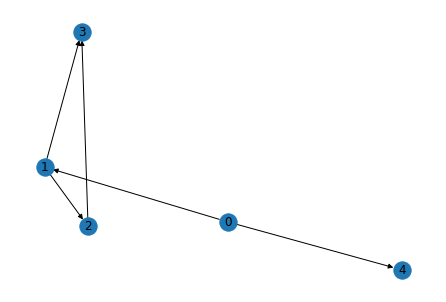

In [45]:
test = np.array([[0,1,0,0, 1], [0,0,1,1,0],[0,0,0,1,0],[0,0,0,0,0],[0,0,0,0,0]])
test_graph = nx.from_numpy_array(test, create_using=nx.DiGraph)
test_adj = nx.adjacency_matrix(test_graph)
pow_1 = test_adj.todense()
pow_2 = pow_1.dot(pow_1)
pow_2_graph = nx.from_numpy_array(pow_2, create_using=nx.DiGraph)
pow_3 = test_adj.dot(pow_2)
pow_3_graph = nx.from_numpy_array(pow_3, create_using=nx.DiGraph)
reachability = pow_1 + pow_2 + pow_3
reachability = nx.from_numpy_array(reachability, create_using=nx.DiGraph)
nx.draw(test_graph, with_labels = True)

The following graph shows the second power of the graph which should provide us with all paths of length two. As we can see there are three in total which is exactle what we expected.

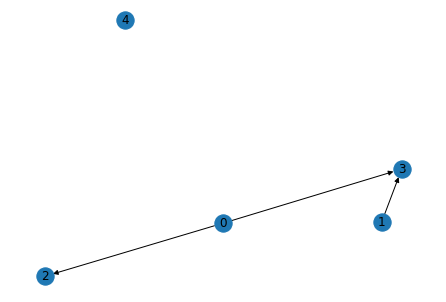

In [35]:
nx.draw(pow_2_graph, with_labels = True)

The following graph shows the third power of the graph, which again, is exactly what we expected. There is exactly one path of length three from zero to three. 

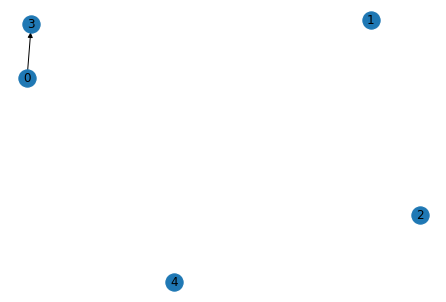

In [37]:
nx.draw(pow_3_graph, with_labels = True)

If we add all the previous powers together we get the reachability graph which is shown below.

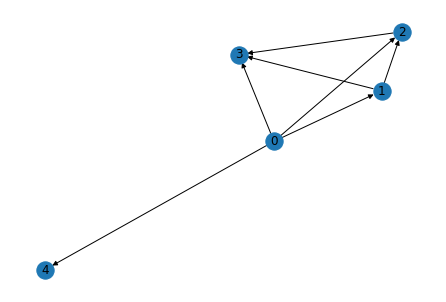

In [39]:
nx.draw(reachability, with_labels = True)

We can apply these ideas to our corporate network and ask ourself if it is possible to reach corporation 251 from corporation 5 in 5 steps. We can answer this question by iterating through the powers of our adjecency matrix and see how many powers it takes until we find a non zero entry. 

In [40]:
# Adjencency matrix of graph
A = nx.adjacency_matrix(G)
# B = np.dot(A, A)
B = A
power = 1
while B[5, 251] == 0:
    B = np.dot(A, B)
    power += 1
    if power == 6:
        print("Have not been able to reach corporation in 5 steps")
        break
# power

Have not been able to reach corporation in 5 steps


In the following we calculate how many paths there are of length n, which we achieve by counting the non-zero elements in the nth power of our adjacency matrix.

In [44]:
res = {}
res[0] = sparse.csr_matrix.count_nonzero(A)
temp = 1
for i in range(1, 100):
    temp = np.dot(A, temp)
    res[i] = sparse.csr_matrix.count_nonzero(temp)
res

{0: 152971,
 1: 152971,
 2: 490049,
 3: 1348141,
 4: 2912922,
 5: 5242844,
 6: 7865123,
 7: 10295713,
 8: 11955880,
 9: 12946356,
 10: 13407213,
 11: 13634976,
 12: 13747625,
 13: 13811048,
 14: 13840608,
 15: 13847043,
 16: 13848071,
 17: 13848833,
 18: 13848071,
 19: 13848833,
 20: 13848071,
 21: 13848833,
 22: 13848071,
 23: 13848833,
 24: 13848071,
 25: 13848833,
 26: 13848071,
 27: 13848833,
 28: 13848071,
 29: 13848833,
 30: 13848071,
 31: 13848833,
 32: 13848071,
 33: 13848833,
 34: 13848071,
 35: 13848833,
 36: 13848071,
 37: 13848833,
 38: 13848071,
 39: 13848833,
 40: 13848071,
 41: 13848833,
 42: 13848071,
 43: 13848833,
 44: 13848071,
 45: 13848833,
 46: 13848071,
 47: 13848833,
 48: 13848071,
 49: 13848833,
 50: 13848071,
 51: 13848833,
 52: 13848071,
 53: 13848833,
 54: 13848071,
 55: 13848833,
 56: 13848071,
 57: 13848833,
 58: 13848071,
 59: 13848833,
 60: 13848071,
 61: 13848833,
 62: 13848071,
 63: 13848833,
 64: 13848071,
 65: 13848833,
 66: 13848071,
 67: 13848833,


We can see that starting power 16 the values 13848071, 13848833 occure repeatadly which implies that there is a circle somewhere in the graph. A circle is a walk $i \rightarrow j \rightarrow k \rightarrow i$, meaning that we end up where we started. 

## Prominence

Now that we are able to compute distances in addtionally to the (in- out) degree of a node, we are able to define metrics that provide an indication of the importance or prominence of a particular node within a network. There are two main concepts. The first is called centrality and the second prestige. Centrality is concerned with "choices made" and prestige with "choices received". 

### Centrality
There are two main indecies that measure centrality: degree and closeness centrality. 

#### Degree centrality
Degree centrality is defined as:
$$
C_d(n_i) := \frac{d_O(n_i)}{g-1} 
$$

where $g$ is the total number of nodes in the network. For our dataset we the following users have the highest degree centrality: 

In [33]:
C_D = nx.out_degree_centrality(G)
C_D_df = pd.DataFrame.from_dict(C_D,orient='index')
C_D_df.sort_values(by = list(C_D_df.columns), ascending=False)

,0
274673392,0.008493
204491797,0.008413
35961145,0.008413
103637045,0.008359
32166535,0.008287
...,...
3063920961,0.000000
896057234,0.000000
85562366,0.000000
75094908,0.000000


#### Closeness centrality
Closeness centrality is defined as:
$$
C_c(n_i) := \frac{g-1}{\sum_{j=1}^g d(n_i, n_j)} 
$$

where $g$ is the total number of nodes in the network and $d$ is the shortest path between node $i$ and $j$. We have to be careful when using this definition because the distance will be infinite if node $j$ is not reachable from node $i$.  For our dataset we the following users have the highest closeness centrality: 


In [34]:
C_C = nx.closeness_centrality(G, wf_improved=True)
C_C_df = pd.DataFrame.from_dict(C_C,orient='index')
C_C_df.sort_values(by = list(C_C_df.columns), ascending=False)

,0
3108351,0.000988
91478624,0.000948
25053299,0.000905
21323268,0.000856
807095,0.000848
...,...
40929570,0.000000
10673252,0.000000
48402711,0.000000
839233893316251648,0.000000


### Prestige
Regarding Prestige there are several approaches among which we are going to discuss:
* Degree-,
* Status / Rank prestige.


#### Degree Prestige
The degree prestige is measured by:

$$
P_D(n_i) = \frac{d_I(n_i)}{g-1}
$$

So it is essentially the weighted indegree of a node. 



In [46]:
P_D = nx.in_degree_centrality(G)
P_D_df = pd.DataFrame.from_dict(P_D,orient='index')
P_D_df.sort_values(by = list(P_D_df.columns), ascending=False)

,0
3108351,0.000824
91478624,0.000779
25053299,0.000645
807095,0.000645
17093617,0.000582
...,...
40929570,0.000000
849979362,0.000000
2588219916,0.000000
426512056,0.000000


#### Status / Rank Prestige
The idea behind the status / rank prestige is that the prestige of a particular node depends on the importance of other nodes "choosing" it. A simple way to describe this relationship would be to say that the prestige of node $i$ is a linear combination of all the other nodes, thus:

$$
P_R(n_i) = X_i'P_R \Rightarrow P_R - X_i'P_R = 0 \Rightarrow  (I - X_i)'P_R = 0
$$

which is the solution to an eigenvalue problem ($\lambda p = X' p$) where $\lambda = 1$. However it is not guaranteed that there exists such an eigenvalue. However if we are able to put constraints on $X'$ such that there exists such an eigenvalue, then this would solve the problem. This is the basic idea behind the eigenvalue and katz prestige. 



In [47]:
P_R_ev = nx.eigenvector_centrality_numpy(G)
P_R_ev

{17137891: 0.009143153141062316,
 86089860: 0.00294023085120138,
 233350057: 0.00227380558084892,
 564708879: 0.002273805580848919,
 1334082998149398529: 0.0022738055808489196,
 101060426: 0.0022738055808489204,
 171213420: 0.0022738055808489187,
 546231933: 0.0022738055808489187,
 1396892023114932224: 0.002273805580848921,
 911426499328319493: 0.00227380558084892,
 1385792643108466696: 0.0022738055808489196,
 244055170: 0.0022738055808489187,
 1002666222: 0.0022738055808489196,
 603299826: 0.002273805580848919,
 471162692: 0.0022738055808489196,
 73732806: 0.0022738055808489196,
 1167313969: 0.00227380558084892,
 180541427: 0.0022738055808489196,
 341330145: 0.0022738055808489187,
 1250455277561839618: 0.00227380558084892,
 842875987: 0.0022738055808489196,
 172415050: 0.002273805580848919,
 893043331361624065: 0.00227380558084892,
 485416525: 0.002273805580848918,
 20798630: 0.002273805580848921,
 1172208715434512384: 0.00227380558084892,
 187075086: 0.00227380558084892,
 221379061: 

In [48]:
P_R_ev_df = pd.DataFrame.from_dict(P_R_ev,orient='index')
sorted_ev_centr = P_R_ev_df.sort_values(by = list(P_R_ev_df.columns), ascending=False)
sorted_ev_centr

,0
91478624,8.468906e-02
3108351,7.424254e-02
25053299,6.771375e-02
21323268,6.391218e-02
816653,6.338149e-02
...,...
64603054,-2.628365e-18
35872799,-2.653112e-18
234826866,-2.825479e-18
140869994,-2.840999e-18


Another closely related to the eigenvector centrality index is the Katz centrality.

In [45]:
P_R_k = nx.katz_centrality(G)

In [42]:
P_R_k_df = pd.DataFrame.from_dict(P_R_k,orient='index')
P_R_k_df.sort_values(by = list(P_R_k_df.columns), ascending=False)

,0
91478624,0.034587
3108351,0.034228
25053299,0.028998
807095,0.026655
21323268,0.026188
...,...
1934702336,0.002422
22551860,0.002422
74524430,0.002422
360018897,0.002422


### Conclusion
This section presented different approaches to detect influencial individuals within a network. We can observe that the nodes: 3108351, 91478624, 25053299, 21323268, 807095 appear on top of different influence measures which leads us to conclude that there is indeed a group of influential corporations in our set. Now That we have detected influential users, we want to seperate the entire network into smaller cohesive communities. In the next section we are discussing methods of how to detect those.   

## Community Detection
Intuitively we would characterize communities as groups that share certain similarites. To translate this idea into the graph thoretic domain, we understand communities as nodes that share common properties and / or play similar roles in a graph. Due to it's wide range of applications such as detection of political opinion groups, customer segmentation, smart- and targeted advertisment and recommendation systems among many other fields and applications. 

In the following we are going to discuss two different approaches to tackle the community detection problem: local and vertex similarity based. Note that most community detection algorithms are defined for undirected graphs. For directed graphs there are various ways to "undirect" them, among which we well use two intuitive approaches. The first is to discard all connections that are not mutual, hence if $A$ is our adjacency matrix then we define $A_R[i,j] = 1 \text{ if } A[i,j] = A[j,i]$ or else $A_R[i,j] = 0$. This approach is also known as recursively connected. The second approach would be the less stringend one where we create mutual connection if there exists a connection in either direction, thus: $A_W = 1 \text{ if } A[i,j] = 1 \text{ or } A[j,i] = 1$ and $A_W[i,j] = 0$ else. We can take a look at the effect of these changes. Originally we have:

In [49]:
print(G.number_of_nodes(), G.number_of_edges())

111616 152971


The size of the graph is too large for standart algorithms to be able to handle so we trim it down by keeping the first 500 most important nodes as classified by the eigenvector centrality. Thus we obtain a subgraph with:

In [50]:
G_cp = G.copy()
d_in  = G_cp.in_degree()
d_out = G_cp.out_degree()
remove_nodes = []
for n in G_cp:
    # print(d_out[n])
    if d_in[n] == 1 and d_out[n] == 0:
        remove_nodes.append(n)

G_cp.remove_nodes_from(sorted_ev_centr.index[500:])
print(G_cp.number_of_nodes(), G_cp.number_of_edges())

500 1184


500 nodes and 1184 edges. Which is still substancial, however we achieved a significant reduction in size by removing the leafe nodes. For the recursively connected graph there are:

In [51]:
G_R = G_cp.to_undirected(reciprocal = True)
G_R.number_of_edges()

7

and for the weakly connected graph there are:

In [54]:
G_W = G_cp.to_undirected()
G_W.number_of_edges()

1177

edges. Thus we can see that the recursive connection reduces the amount of edges to 7, while it reduces the amount of edges by the same amount for the weak connection.

#### Local Similarities
Local similiarity characterizations use local properties of the nodes in order to detect communities. There are four main properties:
* mutuality of ties,
* closeness or reachability,
* frequency of ties and
* relative frequencey of ties within members compared to non-members.  

In order to discuss various approaches for local community detection we need to define some characteristics of a (sub-) graph. Two nodes are $adjacent$ if they are connected by a line. A graph is called:
* $complete$, if all nodes are adjacent to each other and
* $connected$, if there is a path between each pair of nodes

and a subgraph is called $maximal$ with resprect to some property if it holds for the subgraph but not if any other node is being added. A $component$ is a maximal connected subgraph. The existance of two components in a graph implies that the graph is disconnected since there does not exist a path between the two components (by definition), hence not all nodes are reachable from all nodes. In the following we are applying two subgroup models, cliques (modularity based) and k-plexes (frequency of ties based) to our dataset.

##### Cliques
The first and most stringent definition is to define a clique as all nodes where each node is adjacent to each other, in other words aliques are maximal complete subgraphs of size $ \geq 3$. The issue with this definition of a community is that it is very strict: if all nodes are connected to each other except for one pair, it would not be a clique anymore. Thus we would expect there to be only few, small cliques within a graph, which is not necessarely desired.


In [52]:
clique_GR = nx.find_cliques(G_R)
[cl for cl in list(clique_GR) if len(cl) > 2]

[]

In [55]:
nx.graph_clique_number(G_W)

4

Hence we can see that in both cases the maximum clique size is 4 which is a small number considering the amoung of nodes present in the graph.

#### Vertex Similarity
Methods based on vertex similarity group together vertices with similar behaviour. Due to the absense of a dependend variable we er essentially using unsupervised models to  find patterns within our data. Classical techniques for unsupervised learning problems include hierarchical- and spectral clustering and k-means among others. In order to compare different models performance there exists a measure called modularity. We will use this measure as a model selection criterium.

In [59]:
A_GW = nx.adjacency_matrix(G_W).todense()
# A_GR = nx.adjacency_matrix(G_R).todense()

Model estimation:

In [60]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster_lables = cluster.fit_predict(A_GW)
kmeans_gw = KMeans(n_clusters=5, random_state=0).fit(A_GW)
# nx.draw(G_W, node_color=kmeans_gw.labels_)
# kmeans_gw.labels_
sc_gr = SpectralClustering(5, affinity='precomputed', n_init=100, assign_labels='discretize')
sc_gr.fit_predict(A_GW)

/home/vincent/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:723: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/vincent/.local/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Store communities for model selection:

In [63]:
hierarch_communities = [[],[],[],[],[]]
kmeas_communities = [[],[],[],[],[]]
spectral_communities = [[],[],[],[],[]]
for ind, node in enumerate(G_W.nodes()):
    hierarch_communities[cluster_lables[ind]].append(node)
    kmeas_communities[kmeans_gw.labels_[ind]].append(node)
    spectral_communities[sc_gr.labels_[ind]].append(node)

##### Model Selection
Previously we calculate three different unsupervised techniques in order find communities in our corporate network. Next we calculate the modularity for each of the different results and obtain:

In [64]:
print(nx.community.modularity(G_W, hierarch_communities), nx.community.modularity(G_W, kmeas_communities), nx.community.modularity(G_W, spectral_communities))

-0.18253317443004516 0.030615832051447703 0.4514624323897067


We can see that spectral clustering has the highest modularity value which is the model selection criterium. 

### Application
 

Thus far we have achieved to seperate goals. First we detected influential users and second we created the best partition of the graph according to the modularity criterium. While being interesting results in their own rights, combining the two results provides us with means to effectively optimize strategies to influence communities. The most obvious choice would be to seperate communities according and then to pick the most influential user in that group in order to advance the desired goal. The following output tells us who the most influential user in the respective community is.

In [65]:
influential_users = {}
for ind, community in enumerate(spectral_communities):
    most_influential = 0
    temp = 0
    for usr in community:
        # print(sorted_ev_centr.loc[usr] > 0.1)
        if sorted_ev_centr.loc[usr][0] > temp:
            temp = sorted_ev_centr.loc[usr][0]
            most_influential = usr
    influential_users[ind] = {'usr':most_influential, 'value': temp}
influential_users

{0: {'usr': 18994444, 'value': 0.05056321455467011},
 1: {'usr': 21323268, 'value': 0.0639121823361691},
 2: {'usr': 18639734, 'value': 0.05209826066983358},
 3: {'usr': 3108351, 'value': 0.07424254123147161},
 4: {'usr': 91478624, 'value': 0.08468905941808323}}

Note that the most influential users in the respective groups correspond to the users we detected previously. While apprearing self evident, it is not. For example we could very well imagine that the top 5 influential users are all put togther in the same community, then we would not find the others in differnt groups. However we can observe that the spectral clustering manages to put the most influential users in different communities. Which is a desired result.

## Affiliation Networks
Thus far we studied the properties of the corporate network and in particular the relations among the corporations. Another different perspective we can take is to look at how these corporations are similar with respect to  their interests. One way we can achieve this is by looking at affiliations of the corporations to groups. Twitter makes this process rather simple through the existance of hashtags. Hashtags are essentially public folders which can be created by adding the "#" in front of a symbol. By adding a paricular hashtag such as "#halloworld" to a tweet links it automatically to that public folder and displays the tweet there. This allows users to link their tweets to the same hashtag and form groups. We can use this feature to ask ourself if corporations have similar interests by inspected to which hashtags they are associated with. To obtain the hashtags for each user, we downloaded 100 Tweets for each user and extracted the hashtags if present. In total there are 7302 unique hashags in total to which the corporations are linked. Hence we can think of the association between a corporation and the hashtags to which it is linked as a undirected graph with nodes on one side and the hashtags on the other. The particularity of this graph is that we ignore all connections between corporations and focus only on connection between corporations and hashtags. Graphs of this nature are called bipartite graphs and due to the fact that the nodes of this graph come from two different groups (users and hashtags), we have a two mode network. 

### Properties
The first step in analyzing affiliation network is to start with the properties of the corporations and hashtags. 

In [7]:
# returns JSON object as 
f = open('/home/vincent/Dropbox/University/Statistik/KURSE/CURRENT/master/graphT/hashtags.json')
  
# a dictionary
hashtags = json.load(f)
    
# Closing file
f.close()

In [8]:
all_hashtags = []
for hashtag in hashtags:
    all_hashtags.extend(hashtags[hashtag])
len(np.unique(all_hashtags))

7302

In [12]:
BG = nx.Graph()
BG.add_nodes_from(hashtags.keys(), bipartite=0)
BG.add_nodes_from(np.unique(all_hashtags), bipartite=1)
for usr in hashtags:
    for item in hashtags[usr]:
        BG.add_edges_from([(usr, item)])
top_nodes = {n for n, d in BG.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(BG) - top_nodes

BA = bipartite.biadjacency_matrix(BG, top_nodes, bottom_nodes).todense()
# BA_t = np.transpose(BA)
g, h = BA.shape
A = pd.DataFrame(BA, index = top_nodes, columns = bottom_nodes)

##### Corporations
In total we have 307 corporations. A corporation is linked on averages to 32 hashtags, where 75% are linked to 46 hashtags or less.   

In [13]:
A.sum(axis = 1).describe()

count    307.000000
mean      32.775244
std       34.098257
min        0.000000
25%        7.000000
50%       22.000000
75%       46.000000
max      245.000000
dtype: float64

The following plot visualizes the summay statistcs. The red line represents the median and the vertical grey line is the mean. The points in the boxplat can be considered outliers. From the boxplot we can deduce that most corporations are linked to 100 or less hashtags. 

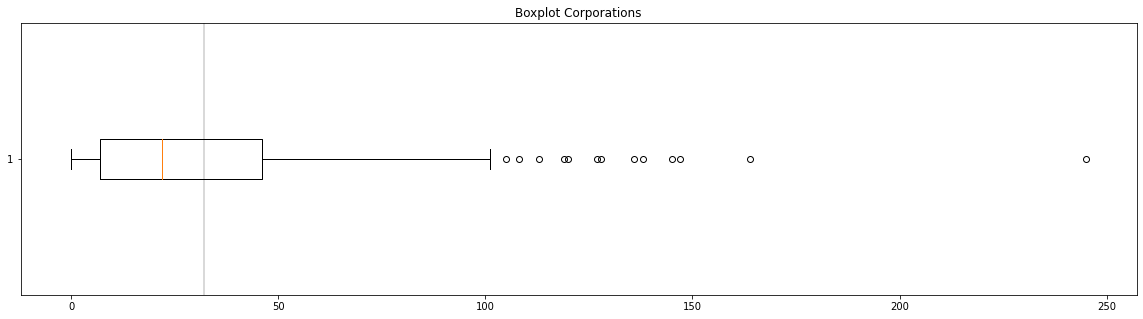

In [15]:
plt.figure(figsize= [20,5])
plt.title("Boxplot Corporations")
plt.boxplot(A.sum(axis = 1), vert = False)
plt.axvline(32,  color = 'black', linewidth = 0.3)

The following plot shows the histogram of the degree distribution of the corporations. We can see there is an exponential decline in the participation of corporations at different hashtags, meaning that most coporations tend to be affilited with less then 50 hashtags. 

<AxesSubplot:title={'center':'Histogram Degree Distribution Corporations'}>

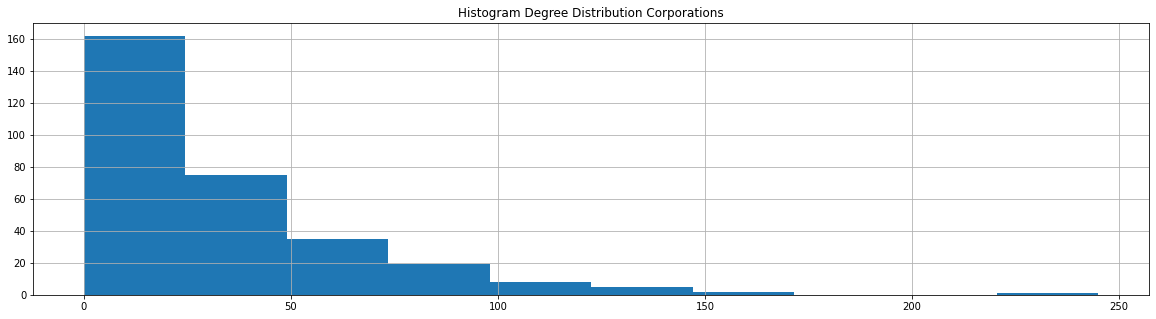

In [16]:
plt.figure(figsize= [20,5])
plt.title("Histogram Degree Distribution Corporations")
A.sum(axis=1).hist()

#### Hashtags
There are 7302 hashtags in total. Of these 75% have 1 corportion linked to it. The average hashtag is linked to 1.3 corporations.

In [17]:
A.sum(axis = 0).describe()

count    7302.000000
mean        1.377979
std         2.214642
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        77.000000
dtype: float64

Looking at the boxplot we can see that the "box" is not present which is a result from almost all values being equal to 1. Furthermore we can observe the presence of many outliers. 

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdb536666d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdb53666c70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdb53666400>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdb53675250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdb53675520>],
 'means': []}

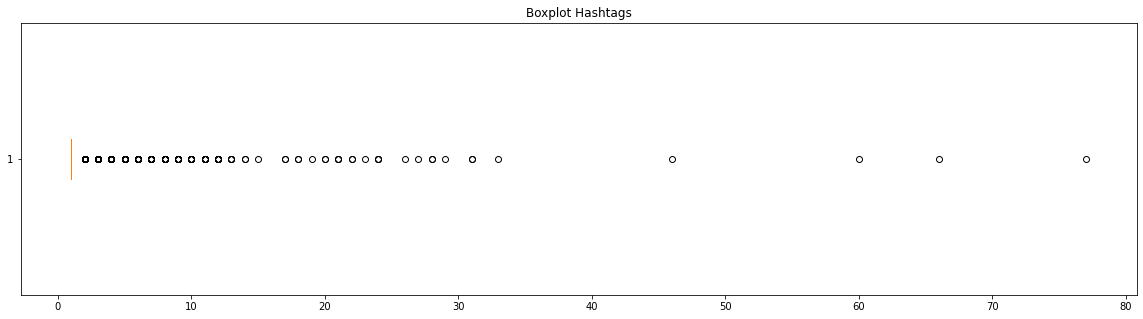

In [18]:
plt.figure(figsize= [20,5])
plt.title("Boxplot Hashtags")
plt.boxplot(A.sum(axis = 0), vert = False)
# plt.axvline(32,  color = 'black', linewidth = 0.3)

Again, from the histogram we can see an exponential decline in the number of hashtags affiliated to users. The histogram reaffirms this observation. There is a very strong decline in the number of corporations affiliated to a particular hashtag. 

<AxesSubplot:title={'center':'Histogram Degree Distibution Hashtags'}>

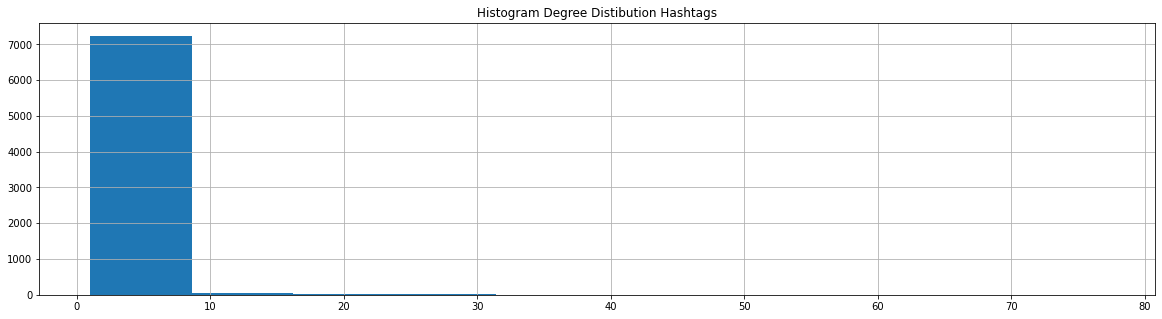

In [19]:
plt.figure(figsize= [20,5])
plt.title("Histogram Degree Distibution Hashtags")
A.sum(axis=0).hist()

In principle we can conduct similar analysis for bipartite graphs as for "normal" ones, but we restrict ourself to a single measure the density.

#### Density
In the following we are interested in finding out how many pairs of corparations share hashtags or vice versus. We can achieve this by looking at the density of either group. Corporations have a density of 0.53 and hashtags of 0.012. This means that 53% of pairs of corporations have posted in at least one same hashtag, while each pair of hashtags share 1% of users. 

In [827]:
A.dot(A.T).sum().sum() / (g*(g-1))

0.5287730727470141

In [798]:
A.T.dot(A).sum().sum() / (h*(h-1))

0.012859567456437777

#### Correspondance Analysis

The basic idea behind correspondence analysis is to find similarityes in different groups. To achieve this goal, first we want to express the data as proportions. We can achieve by subtracting the sum of all values from each observation. Next we want to express these proportions in terms of opposing directions. This can be achieved by subtracting the expected value from each observation. Thus we obtaine values that are greater and smaller then the expected values. Hence we obtained the desired result of opposing signs. This result is called the resudual matrix. Finally, by dividing the residual matrix by  the expected proprtions we obtain a nice interpretation: a particular value is the relative difference from the expected value in percent. For the extual calculations we want to smooth out the variance in the data by deviding the residual matrix by the square root of the expected values and call this matrix the standartized residual matrix. Next we use the standartized residual matrix and perform a singular value decomposition on it. Thus we are able to reduce the data to a lower dimensional space while capturing the maximum amount of variation in the data. In particular by choosing the first to components of the singular value decomposition we effectivly reduce the data to a two dimensions, which allows is to plot and thus draw possible good inference for our data. 

In the following we look at a simple example to explain these ideas. Note that each row in the following matrix represents an observation and a columns a category. 

In [20]:
# data
X = np.array([
    [5,7,2], 
    [18,46,20],
    [19,29,39],
    [12,40,49],
    [3,7,16]])
nrow, ncol = X.shape

The following lines of code present all calculations we need to express the data transformation:

In [21]:
P = X/np.sum(X)
rp_sum = P.dot(np.repeat(1,ncol))
cp_sum = P.T.dot(np.repeat(1,nrow))
E = np.outer(rp_sum, cp_sum)
D_r = np.diag(1/np.sqrt(rp_sum))
D_c = np.diag(1/np.sqrt(cp_sum)) 

Proportions matrix:

In [924]:
P

array([[0.01602564, 0.0224359 , 0.00641026],
       [0.05769231, 0.1474359 , 0.06410256],
       [0.06089744, 0.09294872, 0.125     ],
       [0.03846154, 0.12820513, 0.15705128],
       [0.00961538, 0.0224359 , 0.05128205]])

Expected values for each cell:

In [925]:
E

array([[0.00819773, 0.01855276, 0.0181213 ],
       [0.04918639, 0.11131657, 0.10872781],
       [0.05094305, 0.11529216, 0.11261095],
       [0.05914078, 0.13384492, 0.13073225],
       [0.01522436, 0.03445513, 0.03365385]])

Residual matrix:

In [24]:
R = P - E
P - E

array([[ 0.00782791,  0.00388314, -0.01171105],
       [ 0.00850592,  0.03611933, -0.04462525],
       [ 0.00995439, -0.02234344,  0.01238905],
       [-0.02067924, -0.00563979,  0.02631903],
       [-0.00560897, -0.01201923,  0.01762821]])

Indexed residuals: the first value in the top left corner in the matrix can be interpreted to be 95% more likely to be in the first category then expected.

In [25]:
I = R / E
I

array([[ 0.95488722,  0.20930233, -0.6462585 ],
       [ 0.17293233,  0.32447398, -0.41043084],
       [ 0.1954023 , -0.19379845,  0.11001642],
       [-0.34966128, -0.04213677,  0.20132013],
       [-0.36842105, -0.34883721,  0.52380952]])

By deviding through the square root of the expected values rather than the expected values we essentially take out a part of the variation caused through sampling errors.

In [26]:
R / np.sqrt(E)

array([[ 0.08645676,  0.02850876, -0.08699634],
       [ 0.03835294,  0.10825794, -0.13533506],
       [ 0.04410341, -0.06580368,  0.03691882],
       [-0.0850337 , -0.01541566,  0.07279115],
       [-0.04545838, -0.06475149,  0.09609278]])

Using matrix algegra the entire calculation can be performed in a single step:

In [942]:
(D_r.dot(R)).dot(D_c)

array([[ 0.08645676,  0.02850876, -0.08699634],
       [ 0.03835294,  0.10825794, -0.13533506],
       [ 0.04410341, -0.06580368,  0.03691882],
       [-0.0850337 , -0.01541566,  0.07279115],
       [-0.04545838, -0.06475149,  0.09609278]])

Now that we obtained this matrix we perform singular value decomposition to extract the two most important features which allows us to visualize the data on a two dimensional space. 

In [27]:
U, S, V = np.linalg.svd(R / np.sqrt(E))

We need to undo the previous weighting to obtain the standart coordinates for both the left and right singular values:

The singular values are scaling factors. Each squared singular value tells us how much variance in the data is explained by taking the respective U and V rows / columns. 

In [28]:
S**2 / np.sum(S**2)

array([8.45162886e-01, 1.54837114e-01, 1.82393368e-31])

So the first singualar value captiures 84% and the second around 15%. Hence by choosing the respctive rows and columns we explain 99% of the variation in the data. Next we apply the same methodology to our bimodal graph.

In [854]:
BG_old = BG.copy()
BG = BG_old

Since the graph contains many nodes that contain little information since they have a small degree, we need to reduce the dataset in order to obtain meaningful results. Thus all nodes with a degree of three or less will be removed.

In [29]:
remove = [n for n, d in dict(BG.degree()).items() if d <= 3 ]
BG.remove_nodes_from(remove)
BA = bipartite.biadjacency_matrix(BG, top_nodes, bottom_nodes).todense()

Correspondence calculations:

In [30]:
A_df = pd.DataFrame(BA, index = top_nodes, columns = bottom_nodes)
A_df.shape
n_C = np.sum(np.sum(A_df))
P_C = A_df/n_C

# # print(n_C)
r = np.sum(P_C, axis = 1)
c = np.sum(P_C, axis = 0)
# np.where(r == 0)
D_r = np.diag(np.where(np.isinf(1/np.sqrt(r)), 1, 1/np.sqrt(r)))
D_c = np.diag(np.where(np.isinf(1/np.sqrt(c)), 1, 1/np.sqrt(c)))

Z_C = D_r.dot(P_C - np.outer(r,c)).dot(D_c)

Singular value decomposition:

In [31]:
U_C, S_C, V_C = np.linalg.svd(Z_C)
standard_row_coord = pd.DataFrame(D_r.dot(U_C), index=A_df.index)
standard_col_coord = pd.DataFrame(D_c.dot(V_C.T), index=A_df.columns)
res = pd.concat([standard_row_coord, standard_col_coord])

The following figure plots the explained variance on the y-axis of the respective singular values. The first singular values capture around 2% of the variation in the data, followed by a sharp decline.  

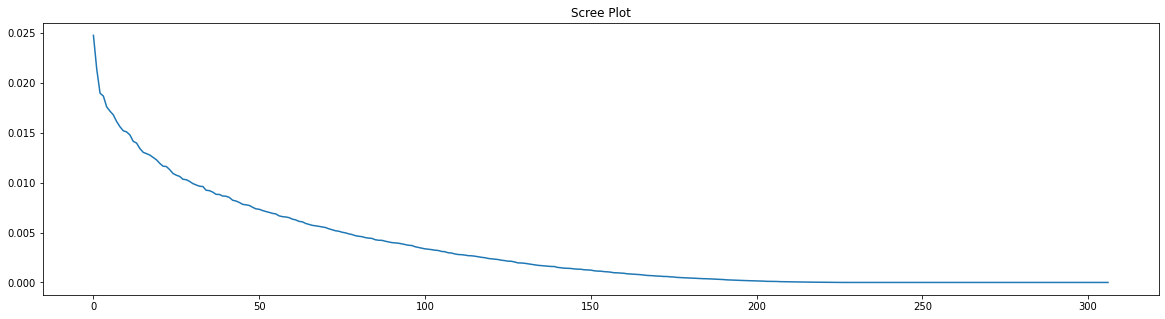

In [33]:
plt.figure(figsize=(20,5))
plt.title("Scree Plot")
plt.plot(S_C**2 / np.sum(S_C**2))

#### Results
Next we are going to discuss the results.

##### Raw Data
The following graph present the results from the correspondence analysis. We can see that there are large outliers to the right and the bottom of the plot and a large mass at the center. We consider outliers if either X or Y value is greater then 2. We subdivide our analysis to focus on the obtained regions. We start on the outside and increasingly narrow it towen towards the center. Users are in green and hashtags are in blue.

In [35]:
# seggragaion into different regions
is_user = [s.isnumeric() for s in res.index]
outliers = np.where(np.array(np.abs(res[0]) > 2) | np.array(np.abs(res[1]) > 2), 1, .1)
middle = np.where(np.array(np.abs(res[0]) <= 2) & np.array(np.abs(res[0]) > .5) | np.array(np.abs(res[1]) <= 2) & np.array(np.abs(res[1]) > .5), 1, .1)
middle_top = np.where(np.array(np.abs(res[0]) <= 2) & np.array(np.abs(res[0]) > .5) | np.array(res[1] <= 2) & np.array(res[1] > .5), 1, .1)
middle_bottom = np.where(np.array(np.abs(res[0]) <= 2) & np.array(np.abs(res[0]) > .5) | np.array(res[1] >= -2) & np.array(res[1] < -.5), 1, .1)
center = np.where(np.array(np.abs(res[0]) <= .5) & np.array(np.abs(res[1]) <= .5), 1, .1)

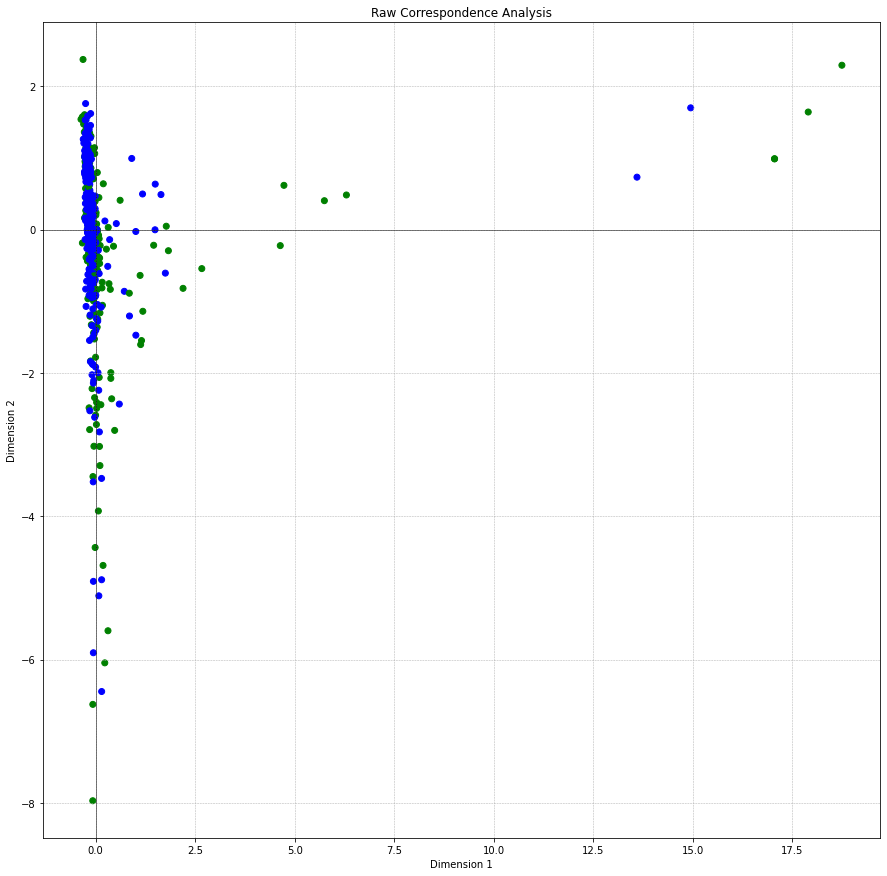

In [37]:
plt.figure(figsize = [15, 15])
plt.title("Raw Correspondence Analysis")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(res[0], res[1], color = np.where(is_user, 'g', 'b'))
# plt.scatter(standard_col_coord[0], standard_col_coord[1],alpha = outliers)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axvline(0, color = 'black', linewidth = 0.5)
plt.grid(linestyle = '--', linewidth = 0.5)

##### Outliers
On the top right corner we can see a group of three corporations which are closest affiliated with the hashtags "DetroidGP" and "NationalDonutDay". There is a group of six coporations towords the center which appear to be affiliated with each other rather then with hashtags. On the bottom center we can see that there is a large group of corporations closely affiliated with hashtags relating to hollidays, such as "StPatricksDay", "ValentinesDay" and "spring".

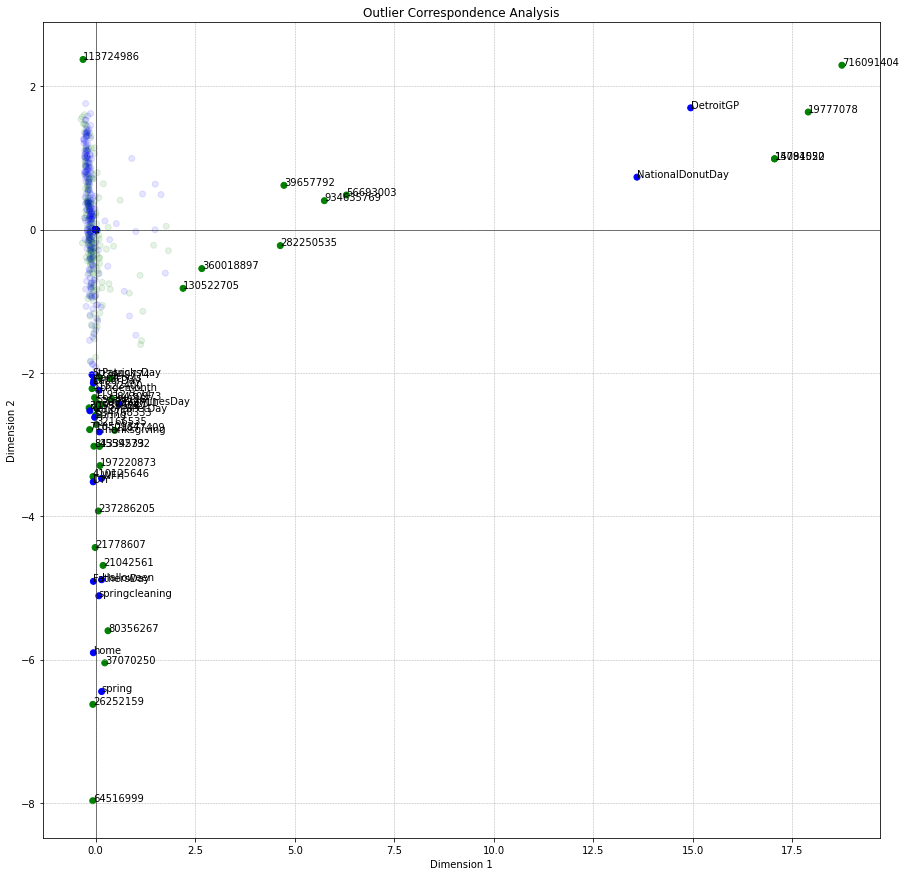

In [38]:
plt.figure(figsize = [15, 15])
plt.title("Outlier Correspondence Analysis")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.scatter(res[0], res[1],alpha = outliers, color = np.where(is_user, 'g', 'b'))
# plt.scatter(standard_col_coord[0], standard_col_coord[1],alpha = outliers)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axvline(0, color = 'black', linewidth = 0.5)
plt.grid(linestyle = '--', linewidth = 0.5)
for i, txt in enumerate(res.index):
    if outliers[i] == 1:
        plt.annotate(txt, (res.iloc[i,0], res.iloc[i,1]))

Moving towods the center there is a "loose" cluster for X values larger then 0.5. For positive Y values we can see hashtags "retail", "news", "NowHiring" amongst others, while for negative Y values we can see "ad", "ChooseToChallenge" and "WorldSeries" amongst others. Furthermore we can observe two dense clusters aroung the center for positive and negative Y values. In the following we well focus on each of them respectively.

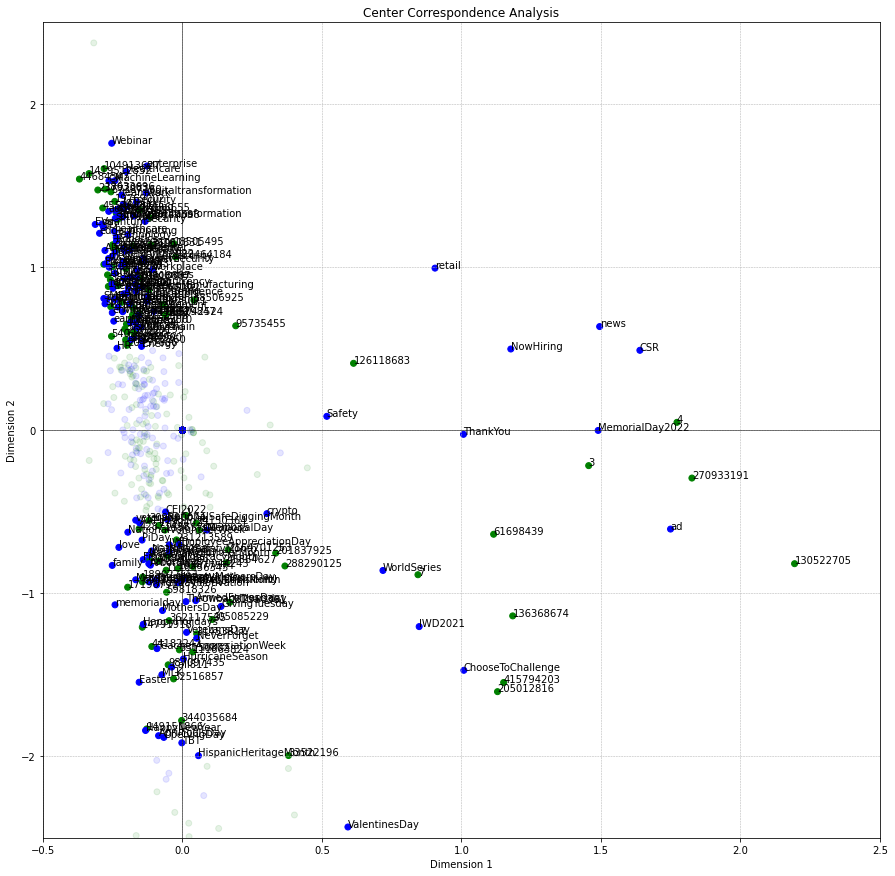

In [39]:
plt.figure(figsize = [15, 15])
plt.title("Center Correspondence Analysis")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim([-.5,2.5])
plt.ylim([-2.5,2.5])
plt.scatter(res[0], res[1],alpha = middle, color = np.where(is_user, 'g', 'b'))
# plt.scatter(standard_col_coord[0], standard_col_coord[1],alpha = outliers)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axvline(0, color = 'black', linewidth = 0.5)
plt.grid(linestyle = '--', linewidth = 0.5)
for i, txt in enumerate(res.index):
    if middle[i] == 1:
        plt.annotate(txt, (res.iloc[i,0], res.iloc[i,1]))

Taking a closer look at to top cluster, we can subdevide the observations into three clusters. In the top cluster, circled in red, we can clearly see that there are corporations associated to hashtags such as "MachineLearning", "digitaltransformation", "quantum", "iot" (Internet of Things). In the blue circle we can find corporations associated with with hashtags such as "Robotics", "CyberSecurity", "military" and "automotive".  The third and bottom cluster circled in cyan we can see a less distinct group of corporations assiciated with hashtags "podcast", "supplychain", "energy" and "diversity". Overall we see that in this section of the entire plot there is an association of corporations to hashtags associated with technology and innovation.

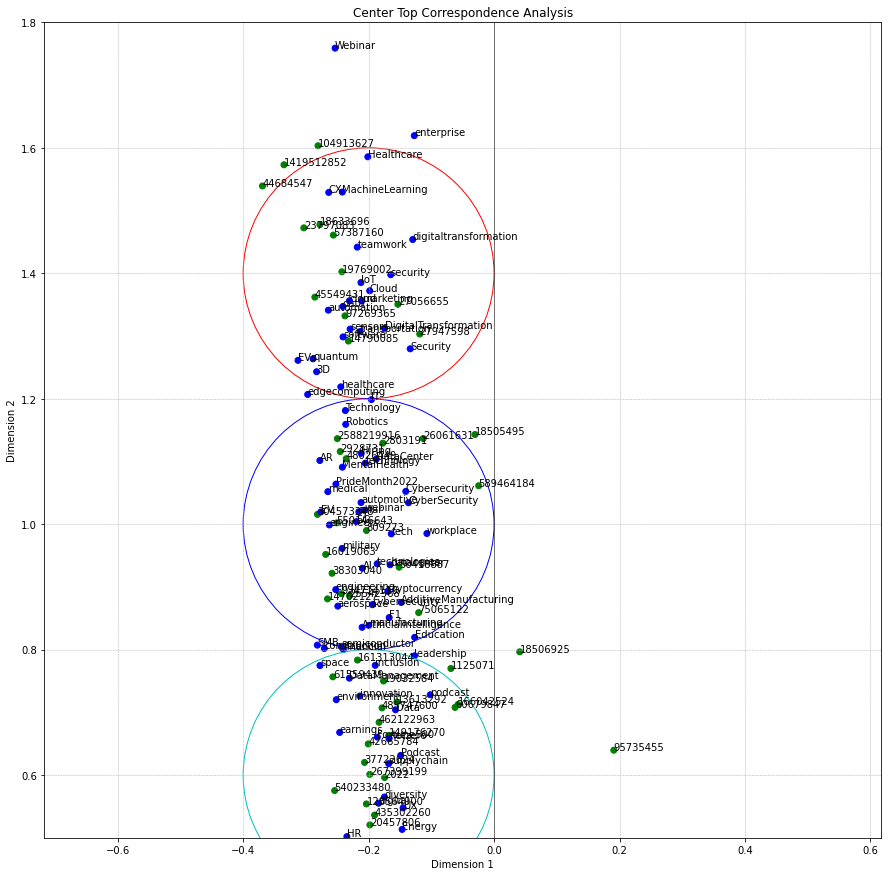

In [43]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title("Center Top Correspondence Analysis")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_xlim([-.4,.3])
ax.set_ylim([0.5,1.8])
ax.axhline(0, color = 'black', linewidth = 0.5)
ax.axvline(0, color = 'black', linewidth = 0.5)
ax.grid(linestyle = '--', linewidth = 0.5)
ax.scatter(res[0], res[1],alpha = middle_top, color = np.where(is_user, 'g', 'b'))
cir1 = plt.Circle((-0.2, 1.4), 0.2, color='r',fill=False)
cir2 = plt.Circle((-0.2, 1.0), 0.2, color='b',fill=False)
cir3 = plt.Circle((-0.2, .6), 0.2, color='c',fill=False)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)
for i, txt in enumerate(res.index):
    if middle_top[i] == 1:
        ax.annotate(txt, (res.iloc[i,0], res.iloc[i,1]))



Regarding the lower dense cluster in the center we can see an overall pattern of corporations associated to hashtags relating to holidays.  

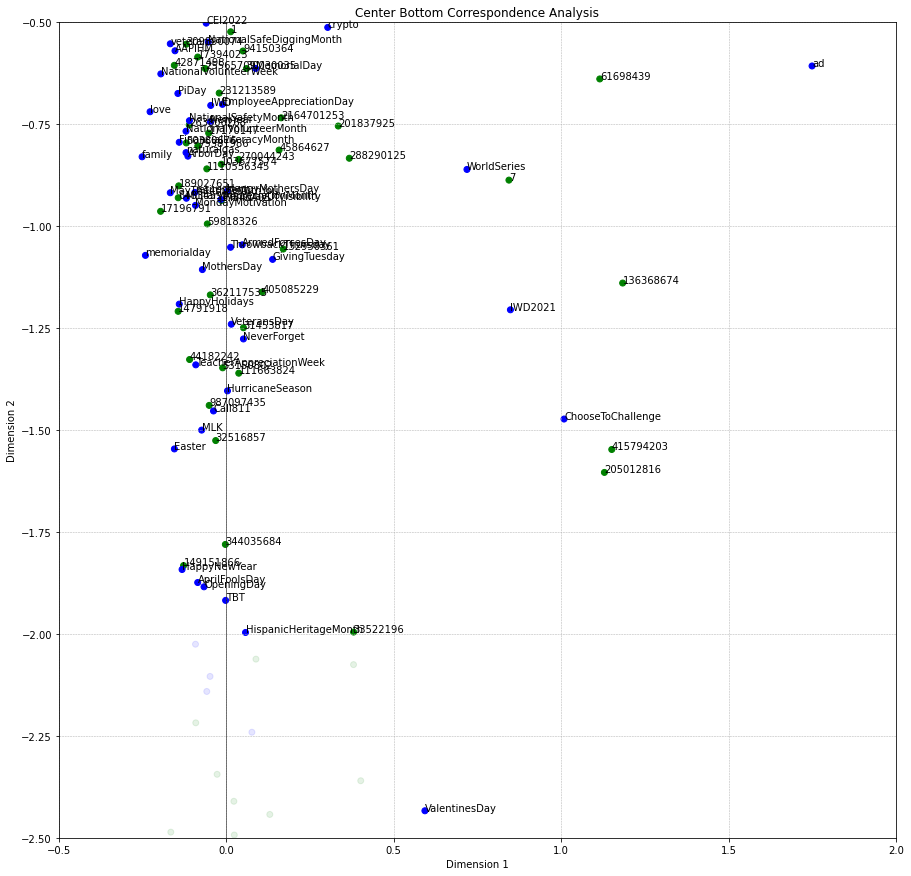

In [42]:
plt.figure(figsize = [15, 15])
plt.title("Center Bottom Correspondence Analysis")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim([-.5,2])
plt.ylim([-2.5,-.5])
plt.scatter(res[0], res[1],alpha = middle_bottom, color = np.where(is_user, 'g', 'b'))
# plt.scatter(standard_col_coord[0], standard_col_coord[1],alpha = outliers)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axvline(0, color = 'black', linewidth = 0.5)
plt.grid(linestyle = '--', linewidth = 0.5)
for i, txt in enumerate(res.index):
    if middle_bottom[i] == 1:
        plt.annotate(txt, (res.iloc[i,0], res.iloc[i,1]))

Regarding the center part of the data, we can see that there is less of a distinction with regard to the difference between technology / innovation and holiday related hashtags. As an overall tendency, the plot confirmes the so far made observations of positve Y values being associated with technology / innovation while negative Y values are more associated with holiday. Although we have to acknloledge that there is a lot more noise in this section.

/home/vincent/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47788 (\N{HANGUL SYLLABLE MON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vincent/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vincent/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53440 (\N{HANGUL SYLLABLE TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/vincent/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50641 (\N{HANGUL SYLLABLE EG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


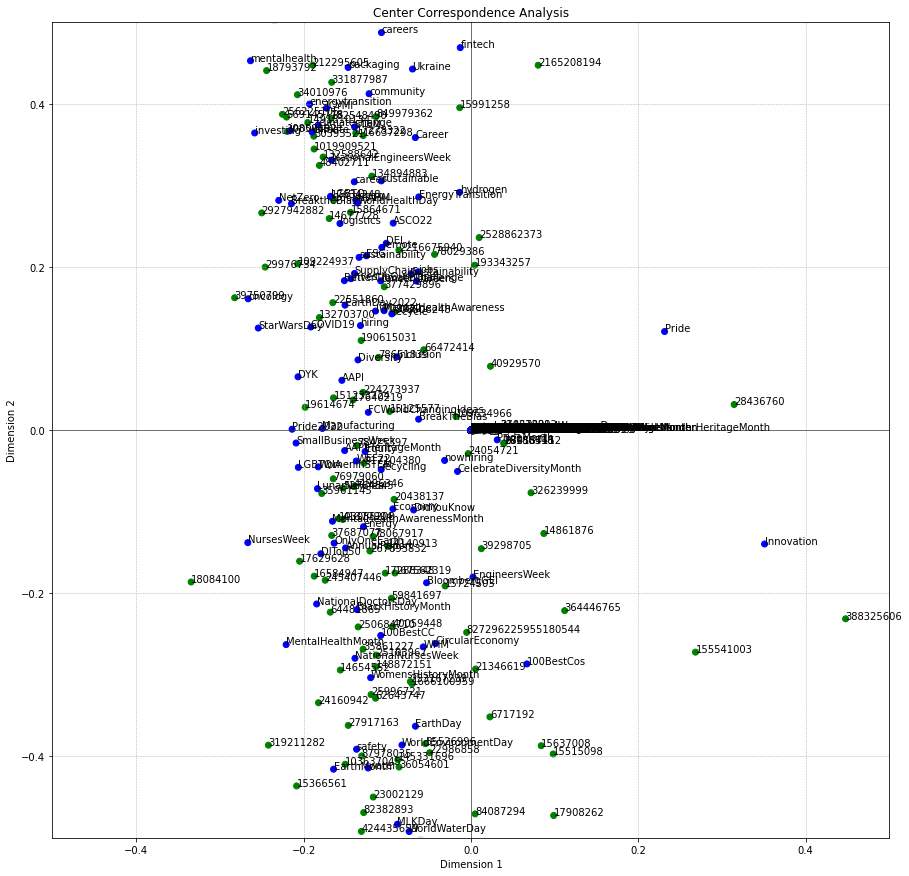

In [44]:
plt.figure(figsize = [15, 15])
plt.title("Center Correspondence Analysis")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.xlim([-.5,.5])
plt.ylim([-.5,.5])
plt.scatter(res[0], res[1],alpha = center, color = np.where(is_user, 'g', 'b'))
# plt.scatter(standard_col_coord[0], standard_col_coord[1],alpha = outliers)
plt.axhline(0, color = 'black', linewidth = 0.5)
plt.axvline(0, color = 'black', linewidth = 0.5)
plt.grid(linestyle = '--', linewidth = 0.5)
for i, txt in enumerate(res.index):
    if center[i] == 1:
        plt.annotate(txt, (res.iloc[i,0], res.iloc[i,1]))